# Preprocessing OCT images
* flatten
* crop
* resize
* get activated region

of images and masks


Source:
* Flattening: Corrects retinal curvature using a plynomial fit to reflective RPE layer.
* https://github.com/forihuelaespina/OCTant/blob/master/src/octant/op/OpScanFlatten.py
* https://github.com/forihuelaespina/OCTant/blob/master/src/octant/op/Operation.py

# Imports

In [36]:
# Import
import warnings
# from deprecated import deprecated


import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
from skimage import io, color

from scipy.optimize import curve_fit

from abc import ABC, abstractmethod

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.figure import Figure
#from matplotlib.backend_bases import KeyEvent, MouseEvent
from skimage import io

import copy #Permits deep copying objects

import scipy.io

import cv2
import numpy as np

import matplotlib.pyplot as plt
import cv2

# Classes

## Super class operation

In [37]:
class Operation(ABC):
    # https://github.com/forihuelaespina/OCTant/blob/master/src/octant/op/Operation.py
    
    def __init__(self,**kwargs):
        """The class constructor.

        The class constructor. Creates an empty operation

        """
        super().__init__()

        #Initialize attributes (without decorator @property)

        #Initialize properties (with decorator @property)
        self.name = 'Operation' #The operation name
        self.operands = list() #Operands
        self.parameters = list() #Parameters
        self.result = None #Operation outputs (a list in case it is multivalued).
                           #None until executed or cleared.

        if kwargs is not None:
            for key, value in kwargs.items():
                if (key=='name'):
                    self.name = value

        return

    #Properties getters/setters
    #
    # Remember: Sphinx ignores docstrings on property setters so all
    #documentation for a property must be on the @property method
    @property
    def operands(self): #operands getter
        """
        The list of operands.

        :getter: Gets the list of operands
        :setter: Sets the list of operands.
        :type: list
        """
        return self.__operands


    @operands.setter
    def operands(self,opList): #operands setter
        #if (not isinstance(opList,(list,))):
        if type(opList) is not list:
            warnMsg = self.getClassName() + ':operands: Unexpected type. ' \
                            'Please provide operands as a list.'
            warnings.warn(warnMsg,SyntaxWarning)
        else:
            self.__operands = opList;
        return None

    @property
    def name(self): #name getter
        """
        The operation name

        :getter: Gets the operation name
        :setter: Sets the operation name.
        :type: string
        """
        return self.__name

    @name.setter
    def name(self,opName): #name setter
        #if (not isinstance(opName,(str,))):
        if type(opName) is not str:
            warnMsg = self.getClassName() + ':name: Unexpected type. ' \
                            'Operations name must be a string.'
            warnings.warn(warnMsg,SyntaxWarning)
        else:
            self.__name = opName;
        return None


    @property
    def parameters(self): #operands getter
        """
        The list of parameters.

        :getter: Gets the list of parameters
        :setter: Sets the list of parameters.
        :type: list
        """
        return self.__parameters


    @parameters.setter
    def parameters(self,opList): #operands setter
        #if (not isinstance(opList,(list,))):
        if type(opList) is not list:
            warnMsg = self.getClassName() + ':parameters: Unexpected type. ' \
                            'Please provide operands as a list.'
            warnings.warn(warnMsg,SyntaxWarning)
        else:
            self.__parameters = opList;
        return None


    @property
    def result(self): #result getter
        """
        The list of results.

        This is a read only property. There is no setter method.

        :getter: Gets the list of results
        :setter: Sets the list of results
        :type: list
        """
        return self.__result


    @result.setter
    def result(self,rList): #result setter
        self.__result = rList;
        return None


    #Private methods
    def __str__(self):
        tmp = '['
        for x in self.operands:
            tmp += format(x) + ','
        tmp+=']'
        s = '<' + self.getClassName() + '([' \
            + 'name: ' + self.name + ';' \
            + ' operands: ' + tmp + '])>'
        return s

    #Public methods
    def getClassName(self):
        """Get the class name as a string.

        Get the class name as a string.

        :returns: The class name.
        :rtype: string
        """
        return type(self).__name__

    def addOperand(self,op,i=None):
        """
        Add a new operand.

        :param op: The operand.
        :type op: object
        :param i: (optional) The operand order. If given it may shift the
            order of other operands already set. If not given, the operand
            is appended at the end of the list of operands.
        :type op: int
        :return: None
        """
        if (i is None):
            self.__operands.append(op)
        else:
            self.__operands.insert(i,op)
        return None

    def setOperand(self,op,i):
        """
        Set an operand; substitutes an existing operand with a new one.

        Calling setOperand when the :py:attr:`i`-th operand has not been
        previously set will result in an out-of-range error.

        :param op: The new operand.
        :type op: object
        :param i: The operand order. Operand index is zero-base i.e. the
            first operand occupies i=0
        :type op: int
        :return: None
        """
        self.__operands[i] = op
        return None

    def addParameter(self,param,i=None):
        """
        Add a new parameter.

        :param op: The parameter.
        :type op: object
        :param i: (optional) The paremeter order. If given it may shift the
            order of other parameters already set. If not given, the parameter
            is appended at the end of the list of parameters.
        :type op: int
        :return: None
        """
        if (i is None):
            self.__parameters.append(op)
        else:
            self.__parameters.insert(i,op)
        return None

    def setParameter(self,op,i):
        """
        Set a parameter; substitutes an existing parameter with a new one.

        Calling setParameter when the :py:attr:`i`-th parameter has not been
        previously set will result in an out-of-range error.

        :param op: The new operand.
        :type op: object
        :param i: The operand order. Operand index is zero-base i.e. the
            first operand occupies i=0
        :type op: int
        :return: None
        """
        self.__operands[i] = op
        return None

    def arity(self):
        """Gets the operation arity (number of operands).

        :return: The operation arity
        :rtype: int
        """
        return len(self.__operands)

    def clear(self):
        """
        Clears the operands; Removes all operands.

        :return: None
        """
        self.__operands = list()
        return None

    #@abstractmethod
    def execute(self,*args,**kwargs):
        """Executes the operation on the operands.

        This is an abstract method. Executes the operation on the .operands
        and stores the outcome in .result

        Operation meta-parameters may be also passed.

        :returns: Result of executing the operation.
        :rtype: Type of result -depends on subclass implementation-.
        """
        pass

## Flatten

In [38]:
class OpScanFlatten(Operation):
    """A flattening operation for :class:`data.OCTscan`.
    
    A flattening operation for :class:`data.OCTscan`.

    The operation represented by this class rectifies an OCT scan.
    
    .. seealso:: None
    .. note:: None
    .. todo:: None
        
    """
 
    #Private class attributes shared by all instances
    
    #Class constructor
    def __init__(self, image, mask=None):
        #Call superclass constructor
        super().__init__()
        
        #Set the operation name
        self.name = "Flattening"
        
        self.__deformationMap = None
        
        self.image = image
        self.mask = mask
        
        return
    
    
    @property
    def deformationMap(self): #name getter
        """
        A logical name for the study.
        
        This is a read only property.
        
        :getter: Gets the deformationMap associated to the last flattening.
        :type: str
        """
        return self.__deformationMap
    


    @staticmethod
    def fittingQuadraticModel(x, a, b, c):
        #quadratic model for curve optimization
        return a * x*x + b*x + c

    
    #Public methods
    def execute(self,*args,**kwargs):
        """Executes the operation on the :py:attr:`operands`.
        
        Executes the operation on the :py:attr:`operands` and stores the outcome
        in :py:attr:`result`. Preload operands using
        :func:`Operation.addOperand()`.
        
        :returns: Result of executing the operation.
        :rtype: :class:`data.OCTscan`
        """
        #print(self._getClasName(),": flattening: Starting flattening")
        
        #Ensure the operand has been set.
        
        
        
        #Check whether the image is in RGB (ndim=3) or in grayscale (ndim=2)
        #and convert to grayscale if necessary
        if self.image.ndim == 2:
            #Dimensions are only width and height. The image is already in grayscale.
            I2=self.image
        elif self.image.ndim == 3:
            #Image is in RGB. Convert.
            I2=color.rgb2gray(self.image);
        else: #Unexpected case. Return warning
            print(self._getClasName(),": Unexpected image shape.")
            self.result = self.image
            return self.result
        
        aux = np.argmax(I2, axis=0)
        mg = np.mean(aux)
        sdg = np.std(aux)
        markers = []
        remover =[]
        x0 = np.arange(len(aux))
        
        for i in range(0,len(aux)):
            if mg - 3*sdg <= aux[i] <= mg +3*sdg: 
                markers+= [aux[i]]
            else:
                remover+= [i]
                
        x=np.delete(x0,remover)
        
        
        
        modelCoeffs, pcov = curve_fit(self.fittingQuadraticModel, x, markers, \
                                    method = 'dogbox', loss = 'soft_l1')
        
        #print(pcov)
        #print(markers)
        
        a = self.fittingQuadraticModel(x0, *modelCoeffs)
        
        #print(a)
        
        shift = np.max(a)
        flat  = shift-a
        flat  = np.round(flat)
        flat  = np.ravel(flat).astype(int)
        self.__deformationMap = flat
        
        newgray = I2
        for i in range(0,len(a)):
            newgray[:,i] = np.roll(I2[:,i], flat[i], axis=0)

        self.result = newgray
        
        # mask part
        try:
            #print(self.__deformationMap)

            self.new_mask = []
            if self.mask is not None:
                for layer in self.mask:
                    self.new_mask.append(layer + self.__deformationMap)
        except Exception as e:
            print("no mask possible")
            return self.result, []
        
        
        
            
        return self.result, self.new_mask


    def applyOperation(self, scanA):
        """Apply the current flattening to the given scan.
        
        Instead of calculating the fitting again needed for the
        flattening, this method applies a known fitted quadratic model to
        the given parameters.
        
        The result is NOT stored in :py:attr:`result`.
        
        :param scanA: Image to flatten.
        :type scanA: :class:`data.OCTscan`
        :returns: Result of repeating the last flattening operation onto
             parameter scanA.
        :rtype: :class:`data.OCTscan`
        """
            #scanA=scanA.data
        newgray = scanA
        for i in range(0,len(self.deformationMap)):
            newgray[:,i] = np.roll(scanA[:,i], self.deformationMap[i], axis=0)
        return newgray

# Run code

## open image and mask

In [64]:
# Test.py

print("Init testing...")
print("Loading image.")
filename = '../examples/example_data/octa500/10001/200.bmp'
#filename = '../examples/example_data/biobank/fds_testing_62.png'

img = io.imread(filename)

base_path = "../examples/example_data/octa500"
mat = scipy.io.loadmat(os.path.join(base_path, "10001.mat")    )
mask = mat["Layer"]

print("layers x a x b (or b x a ??):", mask.shape)

id_minus_one = 200-1

Init testing...
Loading image.
layers x a x b (or b x a ??): (6, 400, 400)


In [68]:
mat["Layer"][:, id_minus_one]

array([[217, 217, 217, ..., 264, 264, 264],
       [242, 242, 243, ..., 292, 292, 292],
       [260, 261, 261, ..., 308, 308, 307],
       [285, 286, 286, ..., 332, 332, 332],
       [302, 302, 302, ..., 345, 345, 345],
       [307, 307, 307, ..., 353, 354, 354]], dtype=uint16)

## run flatten

In [40]:
print("-- Flattening.")
flt = OpScanFlatten(img.copy(), mat["Layer"][:, id_minus_one].copy())
imFlattened, mask_flattened = flt.execute()
print("Done.")       

-- Flattening.
Done.


In [41]:
try:
    mask_flattened[0]
except:
    print("potentially no mask found")

## run cropping

In [42]:
# load image as grayscale

#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#  * 255
gray = (imFlattened).astype(np.uint8)  

gray = cv2.GaussianBlur(gray,(5,5),0)

# threshold 
thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
hh, ww = thresh.shape

# make bottom 2 rows black where they are white the full width of the image
thresh[hh-3:hh, 0:ww] = 0

# get bounds of white pixels
white = np.where(thresh==255)
xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])
print("xmin, xmax, ymin, ymax:", xmin, xmax, ymin, ymax)

padding = 10

# crop the image at the bounds adding rows at the top and bottom (y)
crop = gray[ymin-padding:ymax+padding, xmin:xmax+1]

print("gray shape:", gray.shape)
print("crop shape:", crop.shape)

mask_cropped = mask_flattened.copy()

for i in range(len(mask_cropped)):
    mask_cropped[i] = mask_cropped[i]-ymin+padding+1 # +1 looks better ...

xmin, xmax, ymin, ymax: 0 399 261 445
gray shape: (640, 400)
crop shape: (204, 400)


## run resize

In [43]:
size = 28
new_size = (size, size)

# image
resized = cv2.resize(crop, new_size)

# mask

try:
    # Calculate scaling factors
    scale_x = new_size[0] / crop.shape[1]
    scale_y = new_size[1] / crop.shape[0]

    # Scale the coordinates
    # scaled_coordinates = coordinates * [scale_x, scale_y]

    print("crop shape from threshold:", crop.shape)

    # mask_resized_layerid
    mask_resized_0 = list(np.resize(mask_cropped[0], (new_size)))
    mask_resized_1 = list(np.resize(mask_cropped[1], (new_size)))
    mask_resized_2 = list(np.resize(mask_cropped[2], (new_size)))
    mask_resized_3 = list(np.resize(mask_cropped[3], (new_size)))
    mask_resized_4 = list(np.resize(mask_cropped[4], (new_size)))
    mask_resized_5 = list(np.resize(mask_cropped[5], (new_size)))

    print("length of layer 1:", len(mask_resized_0))

    mask_resized_0 = np.array(list(zip( mask_cropped[0], range(len(mask_cropped[0])) ))) * [scale_y, scale_x]
    mask_resized_1 = np.array(list(zip( mask_cropped[1], range(len(mask_cropped[0])) ))) * [scale_y, scale_x]
    mask_resized_2 = np.array(list(zip( mask_cropped[2], range(len(mask_cropped[0])) ))) * [scale_y, scale_x]
    mask_resized_3 = np.array(list(zip( mask_cropped[3], range(len(mask_cropped[0])) ))) * [scale_y, scale_x]
    mask_resized_4 = np.array(list(zip( mask_cropped[4], range(len(mask_cropped[0])) ))) * [scale_y, scale_x]
    mask_resized_5 = np.array(list(zip( mask_cropped[5], range(len(mask_cropped[0])) ))) * [scale_y, scale_x]

    print("length of layer 1:", len(mask_resized_0))
    
    print("amount of layers:", len(mask_cropped))
except:
    print("potentially no mask found")

crop shape from threshold: (204, 400)
length of layer 1: 28
length of layer 1: 400
amount of layers: 6


In [44]:
mask_cropped[0]

array([34, 34, 33, 33, 33, 33, 32, 32, 32, 32, 31, 31, 31, 31, 30, 30, 30,
       30, 29, 29, 28, 28, 28, 28, 27, 27, 26, 27, 26, 26, 25, 26, 25, 25,
       24, 25, 25, 24, 24, 24, 24, 23, 24, 23, 23, 23, 23, 23, 22, 23, 22,
       22, 23, 22, 22, 22, 22, 21, 21, 22, 21, 21, 21, 21, 21, 21, 21, 20,
       21, 21, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 19, 20, 20, 20, 20, 20, 20, 20, 20, 19, 20, 20, 19, 19, 20, 19,
       19, 19, 20, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 19, 19, 20, 19,
       19, 20, 20, 19, 20, 20, 20, 20, 20, 21, 20, 20, 21, 21, 21, 21, 21,
       22, 21, 22, 22, 23, 22, 23, 23, 23, 23, 23, 24, 24, 25, 24, 25, 25,
       26, 26, 26, 27, 27, 28, 27, 28, 28, 29, 30, 30, 30, 31, 32, 33, 34,
       34, 35, 36, 37, 38, 39, 39, 40, 41, 42, 42, 43, 43, 44, 45, 46, 47,
       48, 49, 49, 50, 50, 51, 52, 53, 53, 54, 53, 54, 54, 55, 55, 55, 55,
       55, 55, 54, 54, 54, 54, 53, 53, 52, 52, 51, 50, 50, 48, 47, 46, 46,
       45, 44, 43, 42, 41

In [45]:
len(mask_resized_0)

400

In [46]:
np.resize(mask_cropped[0], (new_size)).shape

(28, 28)

In [47]:
mask_resized_0.shape

(400, 2)

# Plot

## plot original

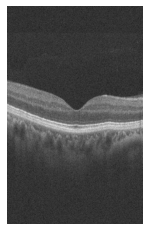

In [48]:
plt.imshow(img, cmap="gray")
plt.axis('off')  # Optional: to turn off the axis
plt.show()

In [49]:
# plot original + mask

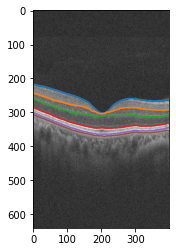

In [50]:
plt.imshow(img, cmap="gray")
#plt.axis('off')  # Optional: to turn off the axis
if "octa500" in filename:
    plt.plot(mask[0, id_minus_one])
    plt.plot(mask[1, id_minus_one])
    plt.plot(mask[2, id_minus_one])
    plt.plot(mask[3, id_minus_one])
    plt.plot(mask[4, id_minus_one])
    plt.plot(mask[5, id_minus_one])
#plt.gca().invert_yaxis()
plt.show()

## plot flattened image

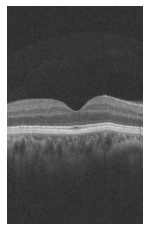

In [51]:
plt.imshow(imFlattened, cmap="gray")
plt.axis('off')  # Optional: to turn off the axis
plt.show()

## plot flattened + mask

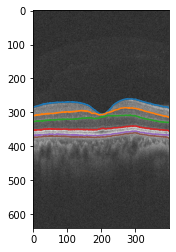

In [52]:
plt.imshow(imFlattened, cmap="gray")
try:
    plt.plot(mask_flattened[0])
    plt.plot(mask_flattened[1])
    plt.plot(mask_flattened[2])
    plt.plot(mask_flattened[3])
    plt.plot(mask_flattened[4])
    plt.plot(mask_flattened[5])
except:
    print("potentially no mask found")
plt.show()

## plot thresholded image

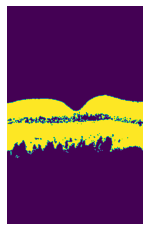

In [53]:
plt.imshow(thresh)
plt.axis('off')  # Optional: to turn off the axis
plt.show()

## plot cropped image + mask

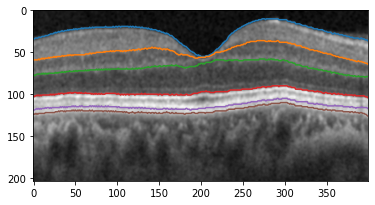

In [54]:
plt.imshow(crop, cmap="gray")
# plt.axis('off')  # Optional: to turn off the axis
try:
    plt.plot(mask_cropped[0])
    plt.plot(mask_cropped[1])
    plt.plot(mask_cropped[2])
    plt.plot(mask_cropped[3])
    plt.plot(mask_cropped[4])
    plt.plot(mask_cropped[5])
except:
    print("potentially no mask found")
plt.show()

## plot resized

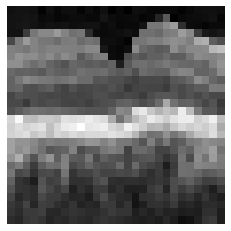

In [55]:
plt.imshow(resized, cmap="gray")
plt.axis('off')  # Optional: to turn off the axis
plt.show()

## plot resized + mask

In [59]:
mask_resized_0

array([[ 4.66666667,  0.        ],
       [ 4.66666667,  0.07      ],
       [ 4.52941176,  0.14      ],
       [ 4.52941176,  0.21      ],
       [ 4.52941176,  0.28      ],
       [ 4.52941176,  0.35      ],
       [ 4.39215686,  0.42      ],
       [ 4.39215686,  0.49      ],
       [ 4.39215686,  0.56      ],
       [ 4.39215686,  0.63      ],
       [ 4.25490196,  0.7       ],
       [ 4.25490196,  0.77      ],
       [ 4.25490196,  0.84      ],
       [ 4.25490196,  0.91      ],
       [ 4.11764706,  0.98      ],
       [ 4.11764706,  1.05      ],
       [ 4.11764706,  1.12      ],
       [ 4.11764706,  1.19      ],
       [ 3.98039216,  1.26      ],
       [ 3.98039216,  1.33      ],
       [ 3.84313725,  1.4       ],
       [ 3.84313725,  1.47      ],
       [ 3.84313725,  1.54      ],
       [ 3.84313725,  1.61      ],
       [ 3.70588235,  1.68      ],
       [ 3.70588235,  1.75      ],
       [ 3.56862745,  1.82      ],
       [ 3.70588235,  1.89      ],
       [ 3.56862745,

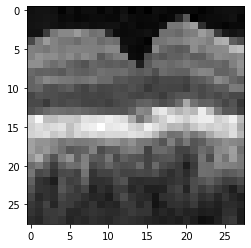

In [60]:
plt.imshow(resized, cmap="gray")


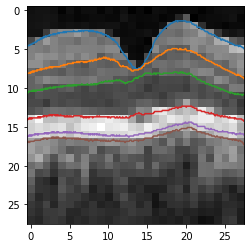

In [63]:
plt.imshow(resized, cmap="gray")

# mask_resized_0[1:,] has size 399, 2 ... not good ...

# todo: [ 39.5, 223.44 ]]) -> last value doesn't reach image size of 224
try:
    # -0.5 to account for pixels starting in center
    plt.plot(mask_resized_0[:,1]-0.5, mask_resized_0[:,0]) # y = 1, x = 0
    plt.plot(mask_resized_1[:,1]-0.5, mask_resized_1[:,0])
    plt.plot(mask_resized_2[:,1]-0.5, mask_resized_2[:,0])
    plt.plot(mask_resized_3[:,1]-0.5, mask_resized_3[:,0])
    plt.plot(mask_resized_4[:,1]-0.5, mask_resized_4[:,0])
    plt.plot(mask_resized_5[:,1]-0.5, mask_resized_5[:,0])
except Exception as e:
    print("potentially no mask found")
    print(e)
# plt.axis("off")
# plt.gca().invert_yaxis()
plt.show()

## get single layer masks

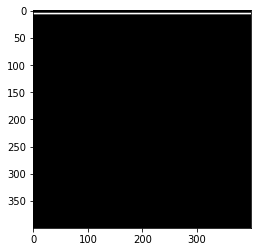

In [57]:
# https://stackoverflow.com/questions/54751676/create-binary-mask-from-two-segmentation-lines-in-python

plt.imshow(resized, cmap="gray")



import matplotlib.pyplot as plt
import numpy as np

im=np.zeros((400, 400)) + 0
r1, r2 = mask_resized_0[:,0], mask_resized_1[:,0]

rows = np.arange(im.shape[0])
m1 = np.logical_and(rows > r1, rows < r2)
im[rows[m1], :] = 255
plt.imshow(im, cmap='gray')


# cv2.contourArea(np.array([mask_resized_0, mask_resized_1]).T.astype(np.float32))

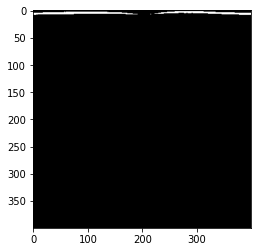

In [58]:
rows, cols = np.indices((400, 400))

mask0 = (rows < mask_resized_1[:,0]) & (rows > mask_resized_0[:,0])

#mask0 = cv2.resize(mask0, new_size)
#mask0 = mask0.resize(new_size)
# mask0 = np.resize(mask0, new_size)

plt.gca().invert_yaxis()
plt.imshow(mask0, origin='lower',cmap='gray')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [34]:
rows < mask_resized_1[:,0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [35]:
np.resize(mask0, new_size).shape

(28, 28)

In [24]:
#mask0.type

In [25]:
mask0

NameError: name 'mask0' is not defined

In [ ]:
import cv2
import numpy as np

# Step 1: Load the image
image = resized # cv2.imread('path_to_your_image.png', cv2.IMREAD_GRAYSCALE)

# Step 2: Define your lines as lists of (x, y) pairs
lines = [
    mask_resized_0,  # Line 1
    mask_resized_1,  # Line 2
    mask_resized_2,  # Line 3
    mask_resized_3,  # Line 4
    mask_resized_4,  # Line 5
    mask_resized_5   # Line 6
]

# Step 3: Extract y-coordinates from each line
y_coords = [int(np.mean([y for _, y in line])) for line in lines]

print(y_coords)

# Step 4: Sort y-coordinates to ensure they are in order
y_coords = sorted(y_coords)

# Step 5: Slice the image into regions
regions = []
previous_y = 0
for y in y_coords:
    regions.append(image[previous_y:y, :])
    previous_y = y

# Add the last region (from the last line to the bottom of the image)
regions.append(image[previous_y:, :])

# Step 6: (Optional) Process each region
mean_pixel_values = [np.mean(region) for region in regions]

# Print the mean pixel values for each region
for i, mean_val in enumerate(mean_pixel_values):
    print(f'Region {i + 1}: Mean pixel value = {mean_val}')


In [ ]:
mask_resized_1

In [26]:
image

NameError: name 'image' is not defined

In [27]:
import cv2
import numpy as np

# Step 1: Load the image
img_tmp = resized

# Step 2: Define regression boundaries (example)
xmin, ymin, xmax, ymax = 50, 50, 200, 200  # Define your own boundaries

# Step 3: Create the mask based on the boundaries
mask_2 = np.zeros(image.shape, dtype=np.uint8)
mask_2[ymin:ymax, xmin:xmax] = 1  # Create a rectangular mask

# Step 4: Extract pixel values in the segmented region
segmented_pixels = image[mask > 0]

# Step 5: Calculate the mean pixel value
mean_pixel_value = np.mean(segmented_pixels)

print(f'Mean pixel value in the segmented region: {mean_pixel_value}')

NameError: name 'image' is not defined

In [28]:
import cv2
import numpy as np

# Step 1: Load the image
image = resized

# Step 2: Define two random lines (y = mx + c)
# Example random slopes and intercepts
m1, c1 = np.random.uniform(-1, 1), np.random.uniform(0, image.shape[0])
m2, c2 = np.random.uniform(-1, 1), np.random.uniform(0, image.shape[0])

# Create a meshgrid of the image dimensions
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

# Step 3: Create the mask between the two lines
# For line 1: y = m1*x + c1
# For line 2: y = m2*x + c2
line1 = Y > (m1 * X + c1)
line2 = Y < (m2 * X + c2)

# Mask where pixels are between the two lines
mask = line1 & line2

# Step 4: Extract pixel values in the masked region
segmented_pixels = image[mask]

# Step 5: Calculate the mean pixel value
mean_pixel_value = np.mean(segmented_pixels)

print(f'Mean pixel value between the two lines: {mean_pixel_value}')

Mean pixel value between the two lines: 122.11066398390342


In [29]:
mask

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
        False